In [ ]:
import pickle

paths = [
    "data/output/vqa_train.pkl",
    "data/output/vqa_val.pkl",
    "data/output/answer_vocab.pkl",
]

for path in paths:
    print("-----", path, "-----")
    with open(path, "rb") as f:
        obj = pickle.load(f)
    print("Type:", type(obj))
    if isinstance(obj, list):
        print("Length:", len(obj))
        print("Example:", obj[0])
    elif isinstance(obj, dict):
        key = next(iter(obj))
        print("Example key:", key)
        print("Example value:", obj[key])
    print()

In [1]:
from configs.experiment_configs import get_config
from models.vqa_model import VQAModel
from training.vqa_training import train_vqa
from training.vqa_training import VQADataset
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import time
from transformers import BertTokenizer
from tqdm import tqdm
import random

In [2]:
start = time.time()
vocab_pkl = "data/output/answer_vocab.pkl"
train_pkl = "data/output/vqa_train.pkl"
val_pkl = "data/output/vqa_val.pkl"
config = get_config("vqa_joint")

# Train on a small subset for testing
model = train_vqa(
    config,
    train_pkl,
    val_pkl,
    vocab_pkl,
    epochs=12,
    batch_size=16,
    lr=1e-4,
    limit=20000
)
end = time.time()
print(f"Cell execution time: {(end - start)/60:.2f} minutes")

Building model...
Using device: mps
Encoders frozen for warm-up
Loading datasets...

Epoch 1/12
Train Loss: 4.1319 | Train Acc: 0.2142
Val Accuracy: 0.2175
Time Taken: 857.0499849319458

Epoch 2/12
Train Loss: 3.6832 | Train Acc: 0.2334
Val Accuracy: 0.2617
Time Taken: 831.9368298053741

Epoch 3/12
Train Loss: 3.4110 | Train Acc: 0.2642
Val Accuracy: 0.2636
Time Taken: 842.7005429267883

Epoch 4/12
Train Loss: 3.1936 | Train Acc: 0.2877
Val Accuracy: 0.2888
Time Taken: 843.7194888591766

Epoch 5/12
Train Loss: 3.0263 | Train Acc: 0.3006
Val Accuracy: 0.2969
Time Taken: 861.748605966568

Epoch 6/12
Train Loss: 2.8862 | Train Acc: 0.3109
Val Accuracy: 0.3038
Time Taken: 898.1310861110687

Epoch 7/12
Encoders unfrozen — training full model
Train Loss: 2.7097 | Train Acc: 0.3120
Val Accuracy: 0.3031
Time Taken: 1784.030632019043

Epoch 8/12
Train Loss: 2.4904 | Train Acc: 0.3381
Val Accuracy: 0.3182
Time Taken: 1816.408033132553

Epoch 9/12
Train Loss: 2.4646 | Train Acc: 0.3515
Val Accura

In [3]:
def show_vqa_prediction(model, image_path, question, device='cpu'):
    """
    Display an image along with a question and the model's predicted answer.

    Args:
        model: VQAModel instance
        image_path: path to the image file
        question: question string about the image
        device: 'cpu' or 'cuda'
    """
    # Create idx -> answer mapping
    idx_to_ans = {v: k for k, v in model.answer_ids.items()}

    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)  # (1, 3, 224, 224)

    # Ensure the model is on the same device
    model.to(device)
    model.eval()

    with torch.no_grad():
        # Tokenize question
        tokens = model.q_tokenizer(
            question,
            padding="max_length",
            truncation=True,
            max_length=model.config["vqa"].question_max_length,
            return_tensors="pt"
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}

        # Forward pass
        logits = model(img_tensor, tokens["input_ids"], tokens["attention_mask"])
        pred_id = torch.argmax(logits, dim=1).item()

        # Map index back to answer string
        answer = idx_to_ans.get(pred_id, "<UNK>")

    # Display image with question and answer
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Q: {question}\nA: {answer}")
    plt.show()

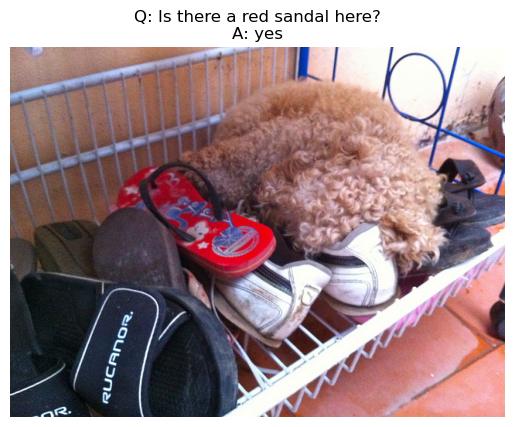

In [4]:
show_vqa_prediction(
    model,
    "data/coco/val2014/COCO_val2014_000000000042.jpg",
    "Is there a red sandal here?",
    device='cpu'
)

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

val_dataset = VQADataset(
    pkl_file=val_pkl,
    tokenizer=tokenizer,
    max_length=config["vqa"].question_max_length,
    is_train=False,
    limit=None
)

In [6]:
len(val_dataset)

185991

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

correct = 0
incorrect = 0

N = 10000  # e.g., check first 1000 val samples for speed
for i in tqdm(range(N)):
    item = val_dataset[i]
    img = item["image"].unsqueeze(0).to(device)
    ids = item["input_ids"].unsqueeze(0).to(device)
    mask = item["attention_mask"].unsqueeze(0).to(device)
    gt = item["answer"].item()

    with torch.no_grad():
        logits = model(img, ids, mask)
        pred = torch.argmax(logits, dim=1).item()

    if pred == gt:
        correct += 1
    else:
        incorrect += 1

100%|████████████████████████████████████████████████████████| 10000/10000 [12:00<00:00, 13.88it/s]


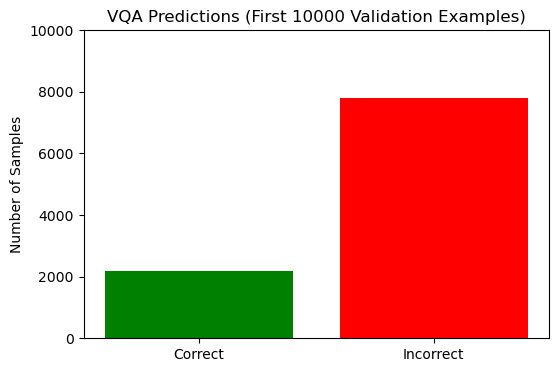

Accuracy: 0.2197
Correct predictions: 2197
Incorrect predictions: 7803


In [8]:
# Data
counts = [correct, incorrect]
labels = ["Correct", "Incorrect"]

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=["green", "red"])
plt.title(f"VQA Predictions (First {N} Validation Examples)")
plt.ylabel("Number of Samples")
plt.ylim(0, N)
plt.show()

# Optional: also show accuracy as text
accuracy = correct / (correct + incorrect)
print(f"Accuracy: {accuracy:.4f}")
print(f"Correct predictions: {correct}")
print(f"Incorrect predictions: {incorrect}")

In [9]:
@torch.no_grad()
def show_random_correct_and_incorrect_fast(model, dataset, tokenizer, idx_to_ans, device="cpu", max_attempts=500):
    """
    Randomly pick one correct and one incorrect example without scanning the entire dataset.
    
    Args:
        model: VQAModel instance
        dataset: VQADataset instance
        tokenizer: tokenizer to decode questions
        idx_to_ans: dict mapping index -> answer string
        device: "cpu" or "cuda"
        max_attempts: max random tries before giving up
    """
    model.eval()
    model.to(device)

    correct_example = None
    incorrect_example = None
    attempts = 0
    N = len(dataset)

    while (correct_example is None or incorrect_example is None) and attempts < max_attempts:
        attempts += 1
        idx = random.randint(0, N-1)
        sample = dataset[idx]

        img = sample["image"].unsqueeze(0).to(device)
        input_ids = sample["input_ids"].unsqueeze(0).to(device)
        mask = sample["attention_mask"].unsqueeze(0).to(device)
        true_idx = sample["answer"].item()

        true_ans = idx_to_ans.get(true_idx, "<UNK>")
        if true_ans == "<UNK>":
            continue  # skip unknown targets

        # Decode question text
        question = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)

        # Model prediction
        logits = model(img, input_ids, mask)
        pred_idx = logits.argmax(dim=1).item()
        pred_ans = idx_to_ans.get(pred_idx, "<UNK>")

        entry = (sample["image"], question, pred_ans, true_ans)

        if pred_idx == true_idx and correct_example is None:
            correct_example = entry
        elif pred_idx != true_idx and incorrect_example is None:
            incorrect_example = entry

    if correct_example is None or incorrect_example is None:
        print("Could not find both a correct and incorrect sample in random tries.")
        return

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    img, q, p, t = correct_example
    axes[0].imshow(img.permute(1, 2, 0))
    axes[0].set_title(f"CORRECT\nQ: {q}\nPredicted: {p}\nTrue: {t}", fontsize=10)
    axes[0].axis("off")

    img, q, p, t = incorrect_example
    axes[1].imshow(img.permute(1, 2, 0))
    axes[1].set_title(f"INCORRECT\nQ: {q}\nPredicted: {p}\nTrue: {t}", fontsize=10)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

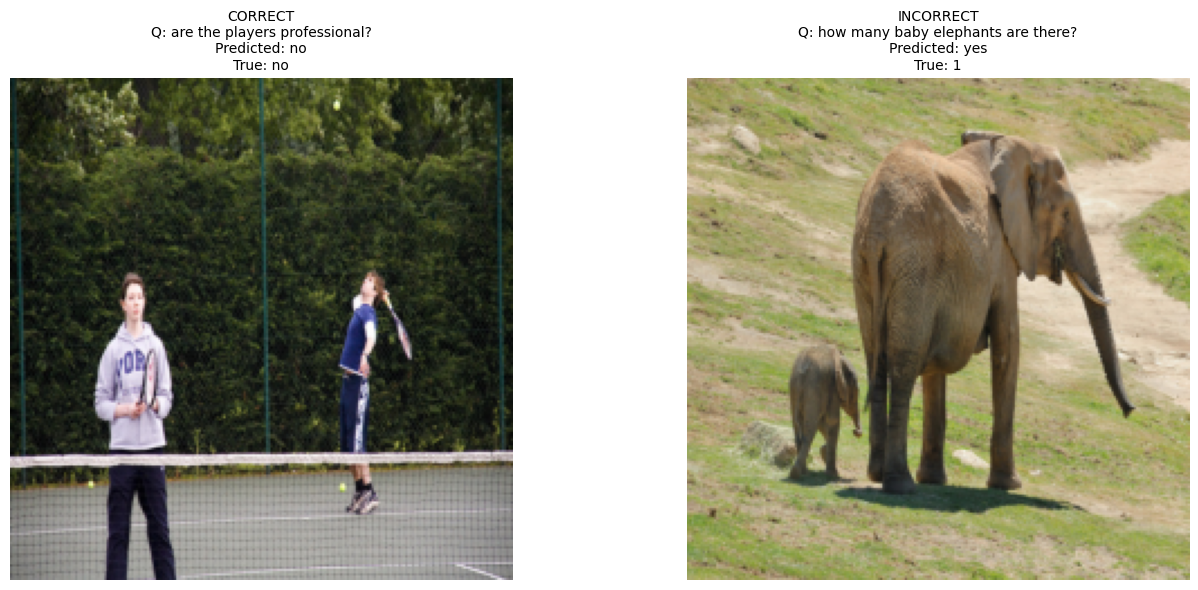

In [15]:
idx_to_ans = {v: k for k, v in model.answer_ids.items()}
show_random_correct_and_incorrect_fast(
    model=model,
    dataset=val_dataset,
    tokenizer=model.q_tokenizer,
    idx_to_ans=idx_to_ans,
    device="cpu"
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

def evaluate_first_100(model, dataset, device='cpu'):
    """
    Returns:
        pred_answers: list of predicted answer IDs
        true_answers: list of ground-truth answer IDs
    """
    model.eval()
    model.to(device)

    pred_answers = []
    true_answers = []

    N = min(100, len(dataset))

    for i in tqdm(range(N)):
        item = dataset[i]

        img = item["image"].unsqueeze(0).to(device)
        ids = item["input_ids"].unsqueeze(0).to(device)
        mask = item["attention_mask"].unsqueeze(0).to(device)
        gt = item["answer"].item()

        with torch.no_grad():
            logits = model(img, ids, mask)
            pred = torch.argmax(logits, dim=1).item()

        pred_answers.append(pred)
        true_answers.append(gt)

    return pred_answers, true_answers


In [ ]:
pred, gt = evaluate_first_100(model, val_dataset, device='cpu')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy
pred = np.array(pred)
gt = np.array(gt)

# Compute accuracy
accuracy = (pred == gt).mean()

print(f"Accuracy on first 100 samples: {accuracy*100:.2f}%")

# Plot
plt.figure(figsize=(5,4))
plt.bar(["Accuracy"], [accuracy])
plt.ylim(0,1)
plt.title("VQA Validation Accuracy (First 100 Examples)")
plt.ylabel("Accuracy")
plt.show()